In [1]:
import torch
import torch.nn as nn
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import random
from time import time as t

In [2]:
image_folder = "Flicker8k_Dataset"
image_names = os.listdir(image_folder)
text_file = "Flickr8k_text/Flickr8k.token.txt"
len(image_names)

8091

In [3]:
image_captions = {}
with open(text_file,"r") as f:
    for line in f:
        split_line = line.strip().split("#")
        image_name = split_line[0]
        caption = split_line[1][2:]
        input_caption = "<sos> " + caption
        output_caption = caption + " <eos>"
        if image_name not in image_captions:
            image_captions[image_name] = [(input_caption,output_caption)]
        else:
            captions = image_captions[image_name]
            captions.append((input_caption,output_caption))
            image_captions[image_name] = captions
print(len(image_captions))

8092


In [4]:
key = list(set(image_captions.keys()).difference(set(image_names)))[0]
print(key)
image_captions.pop(key, None)
print(len(image_captions))

2258277193_586949ec62.jpg.1
8091


### Train and Val

In [5]:
image_names = list(image_captions.keys())
images = []
for idx,img_name in enumerate(image_names):
    im = plt.imread(image_folder+"/"+img_name)
    resized_img = cv2.resize(im,(256,256),interpolation=cv2.INTER_AREA)
    images.append(resized_img)
    if idx % 250 == 0: print(idx,end = ' ')
print(len(images))

input_captions, output_captions = [],[]
for el in image_captions.values():
    ip_caption,op_caption = [],[]
    for caption_pair in el:
        ip_caption.append(caption_pair[0].split(" "))
        op_caption.append(caption_pair[1].split(" "))
    input_captions.append(ip_caption)
    output_captions.append(op_caption)
Xtr_i,Xval_i,Xtr_iname,Xval_iname,Xtr_c,Xval_c,Ytr_c,Yval_c = train_test_split(
    images,image_names,input_captions,output_captions,random_state=0,test_size=0.1
)
len(Xtr_i),len(Xval_i),len(Xtr_c),len(Xval_c),len(Ytr_c),len(Yval_c)

0 250 500 750 1000 1250 1500 1750 2000 2250 2500 2750 3000 3250 3500 3750 4000 4250 4500 4750 5000 5250 5500 5750 6000 6250 6500 6750 7000 7250 7500 7750 8000 8091


(7281, 810, 7281, 810, 7281, 810)

In [6]:
def flatten_the_data(condensed_data,is_image=True):
    if is_image:
        flattened_data = []
        for i in range(len(condensed_data)):
            if i%50 == 0: print(i,end=' ')
            for j in range(5):
                flattened_data.append(torch.tensor(condensed_data[i],dtype=torch.float).permute(2,0,1))
        return flattened_data
    else:
        flattened_data = []
        for i,caption_list in enumerate(condensed_data):
            for caption in caption_list:
                if i%50 == 0: print(i,end=' ')
                flattened_data.append(caption)
        return flattened_data

### Classes

In [7]:
class VocabBuilder:
    def __init__(self,text_corpus,unknown_token=None,pad_token=None,sos_token=None,eos_token=None,smallcase=True,
                 min_word_count=3):
        '''
        text_corpus = [
            [caption1,caption2,caption3,..], # for image 1, caption 1 = ["a","yellow","car","drifting",..]
            [caption1,caption2,caption3,..], # for image 2
            ...
        ]
        '''
        self.text_corpus = text_corpus
        self.unknown_token = unknown_token or "<unk>"
        self.pad_token = pad_token or "<pad>"
        self.sos_token = sos_token or "<sos>"
        self.eos_token = eos_token or "<eos>"
        self.smallcase = smallcase
        self.word_count = self.get_word_count()
        self.min_word_count = min_word_count
        self.word_to_index, self.index_to_word = self.get_vocabs()
        
    def get_word_count(self):
        word_count = {}
        for l in self.text_corpus:
            for sentence in l:
                if self.smallcase: sentence = [word.lower() for word in sentence]
                for word in sentence:
                    if word not in word_count: word_count[word] = 1
                    else: word_count[word] += 1
        return word_count
                        
    def get_vocabs(self):
        word_to_index = {}
        index_count = 0
        for l in self.text_corpus:
            for sentence in l:
                if self.smallcase: sentence = [word.lower() for word in sentence]
                for word in sentence:
                    if word not in word_to_index and self.word_count[word] > self.min_word_count:
                        word_to_index[word] = index_count
                        index_count += 1
        word_to_index[self.unknown_token] = index_count
        word_to_index[self.pad_token] = index_count + 1
        if not self.sos_token in word_to_index: word_to_index[self.sos_token] = index_count + 2
        if not self.eos_token in word_to_index: word_to_index[self.eos_token] = index_count + 3
        index_to_word = {v:k for k,v in word_to_index.items()}
        return word_to_index, index_to_word

In [8]:
class EncodeDecode:
    def __init__(self,word_to_index,index_to_word,pad_token,unknown_token,smallcase=True):
        self.smallcase = smallcase
        self.word_to_index = word_to_index
        self.index_to_word = index_to_word
        self.pad_token = pad_token
        self.unknown_token = unknown_token
    
    def get_encoding(self,sentence):
        '''
        sentence can be a string, or a list of words
        '''
        if isinstance(sentence,str): sentence = sentence.split(" ")
        if self.smallcase: sentence =  [word.lower() for word in sentence]
        encoded_sentence = []
        for word in sentence:
            if word in word_to_index: encoded_sentence.append(self.word_to_index[word])
            else: encoded_sentence.append(self.word_to_index[self.unknown_token])
        return encoded_sentence
    
    def get_decoding(self,encoded_sentence):
        '''
        encoded_sentence must be a list of vocab indices.
        Ex: encoded_sentence = [24,21,4,1,..] 
        '''
        sentence = [self.index_to_word[index] for index in encoded_sentence]
        return " ".join(sentence)

In [9]:
class BatchGenerator:
    def __init__(self,Xi,Xc,Yc,batch_size=5,pad_token="<pad>",encode_decode_obj=None):
        '''
        Xi = [im1,im2,im3,...]
        Xc = [[im1_c1,im1_c2,...,im1_c5],[im2_c1,im2_c2,...,im2_c5],...]
        Yc = [[im1_c1,im1_c2,...,im1_c5],[im2_c1,im2_c2,...,im2_c5],..]
        '''
        self.Xi = Xi
        self.Xc = Xc
        self.Yc = Yc
        self.batch_size = batch_size
        self.pad_token = pad_token
        self.encode_decode_obj = encode_decode_obj
        self.num_batches = len(Xi)//batch_size + 1
    
    def get_padded_sequence(self,sequence,max_length):
        if isinstance(sequence,str): sequence = sequence.split()
        len_sequence = len(sequence)
        sequence = sequence + [self.pad_token]*(max_length-len_sequence)
        return sequence
    
    def get_batch(self,index):
        Xi_b = self.Xi[index*self.batch_size:(index+1)*self.batch_size]
        Xi_b_flattened = []
        for i in range(len(Xi_b)):
            for j in range(5):
                Xi_b_flattened.append(Xi_b[i])
        Xi_b_flattened = torch.tensor(Xi_b_flattened,dtype=torch.float).permute(0,3,1,2)
        
        Xc_b = self.Xc[index*self.batch_size:(index+1)*self.batch_size]
        Xc_b_padded = []
        max_sequence_length = 0
        for caption_list in Xc_b:
            for caption in caption_list: 
                if max_sequence_length < len(caption): max_sequence_length = len(caption)
        for caption_list in Xc_b:
            for caption in caption_list: 
                padded_caption = self.get_padded_sequence(caption,max_sequence_length)
                encoded_caption = self.encode_decode_obj.get_encoding(padded_caption)
                Xc_b_padded.append(encoded_caption)
        Xc_b_padded = torch.tensor(Xc_b_padded)
        
        Yc_b = self.Yc[index*self.batch_size:(index+1)*self.batch_size]
        Yc_b_padded = []
        for caption_list in Yc_b:
            for caption in caption_list: 
                padded_caption = self.get_padded_sequence(caption,max_sequence_length)
                encoded_caption = self.encode_decode_obj.get_encoding(padded_caption)
                Yc_b_padded.append(encoded_caption)
        Yc_b_padded = torch.tensor(Yc_b_padded)
        return Xi_b_flattened, Xc_b_padded, Yc_b_padded

In [10]:
class ImageCaptionGeneratorEncoderModel(nn.Module):
    def __init__(self,debug):
        super().__init__()
        self.debug = debug
        self.batchnorm_0 = nn.BatchNorm2d(3)
        self.cnn_1 = nn.Conv2d(in_channels=3,out_channels=16,kernel_size=3,padding=1)
        self.batchnorm_1 = nn.BatchNorm2d(16)
        self.cnn_2 = nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1)
        self.batchnorm_2 = nn.BatchNorm2d(32)
        self.cnn_3 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm_3 = nn.BatchNorm2d(64)
        self.cnn_4 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.batchnorm_4 = nn.BatchNorm2d(128)
        self.cnn_5 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm_5 = nn.BatchNorm2d(256)
        self.cnn_6 = nn.Conv2d(in_channels=256,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm_6 = nn.BatchNorm2d(256)
        self.cnn_7 = nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,padding=1)
        self.batchnorm_7 = nn.BatchNorm2d(512)
        self.cnn_8 = nn.Conv2d(in_channels=512,out_channels=512,kernel_size=3,padding=1)
        self.batchnorm_8 = nn.BatchNorm2d(512)
        self.selu = nn.SELU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(in_features=512,out_features=500)
        
    def forward(self,image):
        image = self.batchnorm_0(image)
        if self.debug: print("Before starting, Image Shape:",image.shape)
        
        image = self.cnn_1(image)
        image = self.selu(image)
        image = self.batchnorm_1(image)
        if self.debug: print("1st conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("1st pool, Image Shape:",image.shape)
        
        image = self.cnn_2(image)
        image = self.selu(image)
        image = self.batchnorm_2(image)
        if self.debug: print("2nd conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("2nd pool, Image Shape:",image.shape)
        
        image = self.cnn_3(image)
        image = self.selu(image)
        image = self.batchnorm_3(image)
        if self.debug: print("3rd conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("3rd pool, Image Shape:",image.shape)
        
        image = self.cnn_4(image)
        image = self.selu(image)
        image = self.batchnorm_4(image)
        if self.debug: print("4th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("4th pool, Image Shape:",image.shape)
        
        image = self.cnn_5(image)
        image = self.selu(image)
        image = self.batchnorm_5(image)
        if self.debug: print("5th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("5th pool, Image Shape:",image.shape)
        
        image = self.cnn_6(image)
        image = self.selu(image)
        image = self.batchnorm_6(image)
        if self.debug: print("6th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("6th pool, Image Shape:",image.shape)
            
        image = self.cnn_7(image)
        image = self.selu(image)
        image = self.batchnorm_7(image)
        if self.debug: print("7th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("7th pool, Image Shape:",image.shape)
            
        image = self.cnn_8(image)
        image = self.selu(image)
        image = self.batchnorm_8(image)
        if self.debug: print("8th conv, Image Shape:",image.shape)
        image = self.maxpool(image)
        if self.debug: print("8th pool, Image Shape:",image.shape)
            
        image = self.flatten(image)
        if self.debug: print("Flattened, Image Shape:",image.shape)
        
        image = self.linear(image)
        if self.debug: print("Linear layer:",image.shape)
        
        return image

class ImageCaptionGeneratorDecoderModel(nn.Module):
    def __init__(self,batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug):
        super().__init__()
        self.debug = debug
        self.bidirectional = make_bidirectional
        self.num_lstm_layers = num_lstm_layers
        self.batch_size = batch_size
        self.embedding = nn.Embedding(vocab_size,embedding_dim)
        self.relu = nn.ReLU()
        self.gru = nn.GRU(input_size=embedding_dim,hidden_size=500,
                            num_layers=num_lstm_layers,bidirectional=make_bidirectional,batch_first=True)
        self.in_features = 500*2 if make_bidirectional else 500
        self.linear = nn.Linear(in_features=self.in_features, out_features=vocab_size)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self,caption,prev_state,is_prev_state_image_encoding=False):
        if self.debug: print("Before starting: Caption Shape:",caption.shape,"Prev State Shape",prev_state.shape)
        
        if is_prev_state_image_encoding:
            # For sending in GRU layer
            first_param = self.num_lstm_layers
            if self.bidirectional: first_param = 2*self.num_lstm_layers
            # if encoded_image.shape is (5,512) [5 is batch_size] & first_param = 4, => (4,5,512)
            prev_state = prev_state.repeat(first_param,1,1)
            if self.debug: print("Image shape for GRU (as ht)",prev_state.shape)
        
        caption = self.embedding(caption)
        caption = self.relu(caption)
        if self.debug: print("Embedding, Caption Shape:",caption.shape)
        
        caption,ht = self.gru(caption,prev_state)
        if self.debug: print("GRU, Caption Shape:",caption.shape,"ht shape",ht.shape)
            
        # Resizing caption for Linear Layer
        caption = caption.reshape(-1,caption.shape[2])
        if self.debug: print("Reshaping Caption Shape:",caption.shape)
        
        caption = self.linear(caption)
        if self.debug: print("Linear Caption Shape:",caption.shape)
        
        op = self.log_softmax(caption)
        if self.debug: print("log_softmax op Shape:",op.shape)
        
        return op,ht
        

#### Putting it all together

In [11]:
pad_token = "<pad>"
unknown_token = "<unk>"
sos_token = "<sos>"
eos_token = "<eos>"
vocab_builder = VocabBuilder(Ytr_c,pad_token=pad_token,unknown_token=unknown_token,
                             sos_token=sos_token,eos_token=eos_token,smallcase=True,min_word_count=5)
word_to_index, index_to_word = vocab_builder.word_to_index, vocab_builder.index_to_word
print(len(word_to_index),len(index_to_word))
print(index_to_word[2058])
print(word_to_index[index_to_word[2058]])

2524 2524
cutting
2058


In [12]:
encode_decode = EncodeDecode(word_to_index,index_to_word,pad_token=pad_token,unknown_token=unknown_token)

### Run it only once when running the notebook for the 1st time

In [16]:
batch_size = 8
batch_generator = BatchGenerator(Xtr_i,Xtr_c,Ytr_c,batch_size=batch_size,pad_token=pad_token,encode_decode_obj=encode_decode)
for i in range(batch_generator.num_batches):
    if i%100 == 0: print(i,end= ' ')
    Xi_b,Xc_b,Yc_b = batch_generator.get_batch(i)
    torch.save(Xi_b,"BatchData_Xi/batch_"+str(i)+".pt")
    torch.save(Xc_b,"BatchData_Xc/batch_"+str(i)+".pt")
    torch.save(Yc_b,"BatchData_Yc/batch_"+str(i)+".pt")

0 100 200 300 400 500 600 700 800 900 

In [18]:
st = t()
device = torch.device("cuda:0")
Xi_b = torch.load("BatchData_Xi/batch_0.pt")
Xc_b = torch.load("BatchData_Xc/batch_0.pt")
Yc_b = torch.load("BatchData_Yc/batch_0.pt")
Xi_b = Xi_b.to(device)
Xc_b = Xc_b.to(device)
Yc_b = Yc_b.to(device)
print(Xi_b.shape,Xc_b.shape,Yc_b.shape)
print(t()-st)

torch.Size([40, 3, 256, 256]) torch.Size([40, 20]) torch.Size([40, 20])
0.030883073806762695


In [19]:
Xc_b[8]

tensor([2523,    0,   28,   29,   40, 2521,   38,   36,   16, 2522, 2522, 2522,
        2522, 2522, 2522, 2522, 2522, 2522, 2522, 2522], device='cuda:0')

In [20]:
batch_size = 8
vocab_size = len(word_to_index)
embedding_dim = 300
num_lstm_layers = 1
make_bidirectional = False

In [21]:
model_encoder = ImageCaptionGeneratorEncoderModel(debug=True).to(device)
model_decoder = ImageCaptionGeneratorDecoderModel(
    batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug=True
).to(device)
loss_fn = nn.NLLLoss()

In [22]:
image = model_encoder(Xi_b)
op,ht = model_decoder(Xc_b,image,is_prev_state_image_encoding=True)
loss_fn = nn.NLLLoss()
print("For loss",Yc_b.reshape(-1).shape)
print(loss_fn(op,Yc_b.reshape(-1)).item())

Before starting, Image Shape: torch.Size([40, 3, 256, 256])
1st conv, Image Shape: torch.Size([40, 16, 256, 256])
1st pool, Image Shape: torch.Size([40, 16, 128, 128])
2nd conv, Image Shape: torch.Size([40, 32, 128, 128])
2nd pool, Image Shape: torch.Size([40, 32, 64, 64])
3rd conv, Image Shape: torch.Size([40, 64, 64, 64])
3rd pool, Image Shape: torch.Size([40, 64, 32, 32])
4th conv, Image Shape: torch.Size([40, 128, 32, 32])
4th pool, Image Shape: torch.Size([40, 128, 16, 16])
5th conv, Image Shape: torch.Size([40, 256, 16, 16])
5th pool, Image Shape: torch.Size([40, 256, 8, 8])
6th conv, Image Shape: torch.Size([40, 256, 8, 8])
6th pool, Image Shape: torch.Size([40, 256, 4, 4])
7th conv, Image Shape: torch.Size([40, 512, 4, 4])
7th pool, Image Shape: torch.Size([40, 512, 2, 2])
8th conv, Image Shape: torch.Size([40, 512, 2, 2])
8th pool, Image Shape: torch.Size([40, 512, 1, 1])
Flattened, Image Shape: torch.Size([40, 512])
Linear layer: torch.Size([40, 500])
Before starting: Caption

#### Reinitalizing Model for actual training

In [44]:
num_batches = batch_generator.num_batches
num_batches

911

In [45]:
model_encoder = ImageCaptionGeneratorEncoderModel(debug=False).to(device)
model_decoder = ImageCaptionGeneratorDecoderModel(
    batch_size,vocab_size,embedding_dim,num_lstm_layers,make_bidirectional,debug=False
).to(device)
epochs = 100
loss_fn = nn.NLLLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [46]:
optimizer_encoder = torch.optim.Adam(model_encoder.parameters(),lr=0.0003)
optimizer_decoder = torch.optim.Adam(model_decoder.parameters(),lr=0.0003)

In [47]:
def predict(model_encoder, model_decoder,image_tensor=None, show_original_captions=False):
    if image_tensor is None:
        im_index = random.randint(1,100)
        image_tensor = torch.tensor([Xtr_i[im_index]],dtype=torch.float).permute(0,3,1,2).to(device)
        plt.imshow(image_tensor[-1].permute(1,2,0).cpu().numpy().astype('int32'))
        plt.show()
        if show_original_captions:
            print("Captions:",Xtr_c[im_index])
            print("Encoded X",encode_decode.get_encoding(Xtr_c[im_index][3]))
            print("Encoded Y",encode_decode.get_encoding(Ytr_c[im_index][3]))
    model_encoder.eval()
    model_decoder.eval()
    with torch.no_grad():
        ht = model_encoder(image_tensor)
        c = torch.tensor([encode_decode.get_encoding('<sos>')]).to(device)
        eos_index = word_to_index["<eos>"]
        caption = []
        for i in range(20):
            if i==0: op,ht = model_decoder(c,ht,is_prev_state_image_encoding=True)
            else: op,ht = model_decoder(c,ht,is_prev_state_image_encoding=False)
            predicted_word = torch.argmax(op,axis=1).tolist()
            caption.append(predicted_word[-1])
            c = torch.tensor([predicted_word]).to(device)
            if predicted_word[-1] == eos_index: break
        print("Encoded Caption:",caption)
        print("Decoded Caption:",encode_decode.get_decoding(caption))

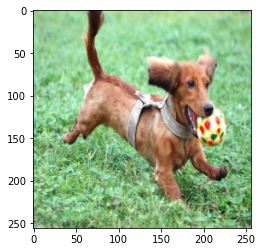

Captions: [['<sos>', 'A', 'brown', 'dog', 'runs', 'happily', 'with', 'a', 'yellow', 'ball', 'in', 'its', 'mouth', '.'], ['<sos>', 'A', 'Dachshund', 'runs', 'through', 'the', 'grass', ',', 'carrying', 'a', 'ball', '.'], ['<sos>', 'A', 'dog', 'runs', 'with', 'a', 'multicolored', 'ball', '.'], ['<sos>', 'A', 'small', 'brown', 'dog', 'running', 'with', 'a', 'multicolored', 'ball', 'in', 'his', 'mouth', '.'], ['<sos>', 'The', 'small', 'dog', ',', 'wearing', 'a', 'harness', ',', 'is', 'running', 'with', 'a', 'ball', 'in', 'its', 'mouth', '.']]
Encoded X [2523, 0, 52, 112, 44, 56, 20, 0, 755, 696, 3, 78, 55, 16]
Encoded Y [0, 52, 112, 44, 56, 20, 0, 755, 696, 3, 78, 55, 16, 9]
Encoded Caption: [1461, 1143, 1674, 2301, 796, 1576, 1576, 131, 2381, 1880, 1576, 131, 2381, 1880, 1576, 131, 2381, 1880, 1576, 131]
Decoded Caption: third emerges balcony alike break licking licking striped pajamas earrings licking striped pajamas earrings licking striped pajamas earrings licking striped


In [48]:
predict(model_encoder, model_decoder, show_original_captions=True)

Epoch: 0 Index: 0 Loss: 7.771907806396484
Epoch: 0 Index: 100 Loss: 0.11985576152801514
Epoch: 0 Index: 200 Loss: 0.08912649750709534
Epoch: 0 Index: 300 Loss: 0.08669330179691315
Epoch: 0 Index: 400 Loss: 0.08588790893554688
Epoch: 0 Index: 500 Loss: 0.08549541980028152
Epoch: 0 Index: 600 Loss: 0.08527828007936478
Epoch: 0 Index: 700 Loss: 0.08515521883964539
Epoch: 0 Index: 800 Loss: 0.08506720513105392
Epoch: 0 Index: 900 Loss: 0.08499021828174591
__________________________________________
Epoch loss........ 208.27476243674755


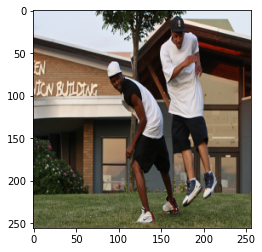

Encoded Caption: [0, 2226, 155, 122, 40, 16, 9]
Decoded Caption: a chubby asian boy is . <eos>
__________________________________________
Epoch: 1 Index: 0 Loss: 0.08497984707355499


KeyboardInterrupt: 

In [49]:
for epoch in range(epochs):
    epoch_loss = 0
    model_encoder.train()
    model_decoder.train()
    for index in range(num_batches):
        optimizer_encoder.zero_grad()
        optimizer_decoder.zero_grad()
        Xi_b = torch.load("BatchData_Xi/batch_"+str(i)+".pt")
        Xc_b = torch.load("BatchData_Xc/batch_"+str(i)+".pt")
        Yc_b = torch.load("BatchData_Yc/batch_"+str(i)+".pt")
        Xi_b = Xi_b.to(device)
        Xc_b = Xc_b.to(device)
        Yc_b = Yc_b.to(device)
        image = model_encoder(Xi_b)
        op,ht = model_decoder(Xc_b,image,is_prev_state_image_encoding=True)
        loss = loss_fn(op,Yc_b.reshape(-1))
        epoch_loss += loss.item()
        loss.backward()
        optimizer_encoder.step()
        optimizer_decoder.step()
        if index % 100 == 0: print("Epoch:",epoch,"Index:",index,"Loss:",loss.item())
    print("__________________________________________")
    print("Epoch loss........",epoch_loss)
    predict(model_encoder,model_decoder)
    print("__________________________________________")

### On Validation Data

In [ ]:
i = 89
img_name = Xval_i[i]
print(Xval_c[i],Yval_c[i])
resized_img = torch.tensor([Xval_i[i]],dtype=torch.float)
resized_img = resized_img.permute(0,3,1,2)
resized_img = resized_img.to(device)
plt.imshow(resized_img[-1].permute(1,2,0).cpu().numpy().astype('int32'))

In [ ]:
predict(model_encoder, model_decoder,image_tensor=resized_img,show_original_captions=False)